In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
from utils.common import (
    m2f_dataset_collate,
    m2f_extract_pred_maps_and_masks,
    BG_VALUE_255,
    set_seed,
    pixel_mean_std,
    CADIS_PIXEL_MEAN,
    CADIS_PIXEL_STD,
)
from utils.dataset_utils import (
    get_cadisv2_dataset,
    get_cataract1k_dataset,
    ZEISS_CATEGORIES,
)
from utils.medical_datasets import Mask2FormerDataset
from transformers import (
    Mask2FormerForUniversalSegmentation,
    SwinModel,
    SwinConfig,
    Mask2FormerConfig,
    AutoImageProcessor,
    Mask2FormerImageProcessor,
)
from torch.utils.data import DataLoader
import evaluate
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from dotenv import load_dotenv
import wandb
from sklearn.cluster import KMeans
import umap
from scipy.spatial.distance import cdist

/Users/kristiyansakalyan/Documents/uni/ZEISS/project/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
set_seed(42) # seed everything

In [4]:
NUM_CLASSES = len(ZEISS_CATEGORIES) - 3  # Remove class incremental
SWIN_BACKBONE = "microsoft/swin-tiny-patch4-window7-224"#"microsoft/swin-large-patch4-window12-384"

# Download pretrained swin model
swin_model = SwinModel.from_pretrained(
    SWIN_BACKBONE, out_features=["stage1", "stage2", "stage3", "stage4"]
)
swin_config = SwinConfig.from_pretrained(
    SWIN_BACKBONE, out_features=["stage1", "stage2", "stage3", "stage4"]
)

# Create Mask2Former configuration based on Swin's configuration
mask2former_config = Mask2FormerConfig(
    backbone_config=swin_config, num_labels=NUM_CLASSES #, ignore_value=BG_VALUE
)

# Create the Mask2Former model with this configuration
model = Mask2FormerForUniversalSegmentation(mask2former_config)

# Reuse pretrained parameters
for swin_param, m2f_param in zip(
    swin_model.named_parameters(),
    model.model.pixel_level_module.encoder.named_parameters(),
):
    m2f_param_name = f"model.pixel_level_module.encoder.{m2f_param[0]}"

    if swin_param[0] == m2f_param[0]:
        model.state_dict()[m2f_param_name].copy_(swin_param[1])
        continue

    print(f"Not Matched: {m2f_param[0]} != {swin_param[0]}")

/Users/kristiyansakalyan/Documents/uni/ZEISS/project/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Not Matched: hidden_states_norms.stage1.weight != layernorm.weight
Not Matched: hidden_states_norms.stage1.bias != layernorm.bias


In [5]:
# Helper function to load datasets
def load_dataset(dataset_getter, data_path, domain_incremental):
    return dataset_getter(data_path, domain_incremental=domain_incremental)


# Helper function to create dataloaders for a dataset
def create_dataloaders(
    dataset, batch_size, shuffle, num_workers, drop_last, pin_memory, collate_fn
):
    return {
        "train": DataLoader(
            dataset["train"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            drop_last=drop_last,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
        ),
        "val": DataLoader(
            dataset["val"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            drop_last=drop_last,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
        ),
        "test": DataLoader(
            dataset["test"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            drop_last=drop_last,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
        ),
    }


# Load datasets
datasets = {
    "A": load_dataset(get_cadisv2_dataset, "data/CaDISv2", True),
    "B": load_dataset(get_cataract1k_dataset, "data/cataract-1k", True),
}

# pixel_mean_A,pixel_std_A=pixel_mean_std(datasets["A"][0])
pixel_mean_A = CADIS_PIXEL_MEAN
pixel_std_A = CADIS_PIXEL_STD

# This time define the B train dataset such that it replays approximately
# 32 MBs of images from the previous dataset. Each image is approximately 700 kBs
# Generate N random indices from dataset A
N = int(32 / 0.7)
random_indices = torch.randperm(len(datasets["A"][0]))[:N]

# Create a subset of B using the randomly sampled indices
subset_A = torch.utils.data.Subset(datasets["A"][0], random_indices)
new_train = torch.utils.data.ConcatDataset([subset_A, datasets["B"][0]])

pixel_mean_B,pixel_std_B=pixel_mean_std(new_train)
print("pixel mean of B",pixel_mean_B,"pixel std:",pixel_std_B)
#pixel_mean_B = REPLAY32_PIXEL_MEAN
#pixel_std_B = REPLAY32_PIXEL_STD

datasets["B"] = (new_train, datasets["B"][1], datasets["B"][2])

# Define preprocessor
swin_processor = AutoImageProcessor.from_pretrained(SWIN_BACKBONE)
m2f_preprocessor_A = Mask2FormerImageProcessor(
    reduce_labels=True,
    ignore_index=255,
    do_resize=False,
    do_rescale=True,
    do_normalize=True,
    image_std=pixel_std_A,
    image_mean=pixel_mean_A,
)

m2f_preprocessor_B = Mask2FormerImageProcessor(
    reduce_labels=True,
    ignore_index=255,
    do_resize=False,
    do_rescale=True,
    do_normalize=True,
    image_std=pixel_std_B,
    image_mean=pixel_mean_B,
)

# Create Mask2Former Datasets

m2f_datasets = {
    "A": {
        "train": Mask2FormerDataset(datasets["A"][0], m2f_preprocessor_A),
        "val": Mask2FormerDataset(datasets["A"][1], m2f_preprocessor_A),
        "test": Mask2FormerDataset(datasets["A"][2], m2f_preprocessor_A),
    },
    "B": {
        "train": Mask2FormerDataset(datasets["B"][0], m2f_preprocessor_B),
        "val": Mask2FormerDataset(datasets["B"][1], m2f_preprocessor_B),
        "test": Mask2FormerDataset(datasets["B"][2], m2f_preprocessor_B),
    },
}

# DataLoader parameters
N_WORKERS = 4
BATCH_SIZE = 16
SHUFFLE = True
DROP_LAST = True

dataloader_params = {
    "batch_size": BATCH_SIZE,
    "shuffle": SHUFFLE,
    "num_workers": N_WORKERS,
    "drop_last": DROP_LAST,
    "pin_memory": True,
    "collate_fn": m2f_dataset_collate,
}

# Create DataLoaders
dataloaders = {
    key: create_dataloaders(m2f_datasets[key], **dataloader_params)
    for key in m2f_datasets
}

print(dataloaders)

/Users/kristiyansakalyan/Documents/uni/ZEISS/project/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


pixel mean of B [0.32157042 0.28951521 0.21150439] pixel std: [0.30117609 0.2538635  0.22088646]
{'A': {'train': <torch.utils.data.dataloader.DataLoader object at 0x319b225d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x319b228d0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x319b226c0>}, 'B': {'train': <torch.utils.data.dataloader.DataLoader object at 0x319b22f00>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x319b22f90>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x319b23050>}}


In [6]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Tensorboard setup
out_dir="outputs/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
if not os.path.exists(out_dir+"runs"):
    os.makedirs(out_dir+"runs")
%load_ext tensorboard
%tensorboard --logdir outputs/runs

In [8]:
#!rm -r outputs

In [24]:
#!CUDA_LAUNCH_BLOCKING=1

# First train on dataset A

In [7]:
# Training
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
LR_MULTIPLIER = 0.1
BACKBONE_LR = LEARNING_RATE * LR_MULTIPLIER
WEIGHT_DECAY = 0.05
PATIENCE=15
metric = evaluate.load("mean_iou")
encoder_params = [
    param
    for name, param in model.named_parameters()
    if name.startswith("model.pixel_level_module.encoder")
]
decoder_params = [
    param
    for name, param in model.named_parameters()
    if name.startswith("model.pixel_level_module.decoder")
]
transformer_params = [
    param
    for name, param in model.named_parameters()
    if name.startswith("model.transformer_module")
]
optimizer = optim.AdamW(
    [
        {"params": encoder_params, "lr": BACKBONE_LR},
        {"params": decoder_params},
        {"params": transformer_params},
    ],
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

scheduler = optim.lr_scheduler.PolynomialLR(
    optimizer, total_iters=NUM_EPOCHS, power=0.9
)

In [11]:
# WandB for team usage !!!!

wandb.login() # use this one if a different person is going to run the notebook
#wandb.login(relogin=False) # if the same person in the last run is going to run the notebook again


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [12]:
wandb.init(
    project="M2F_original",
    config={
        "learning_rate": LEARNING_RATE,
        "learning_rate_multiplier": LR_MULTIPLIER,
        "backbone_learning_rate": BACKBONE_LR,
        "learning_rate_scheduler": scheduler.__class__.__name__,
        "optimizer": optimizer.__class__.__name__,
        "backbone": SWIN_BACKBONE,
        "m2f_preprocessor": m2f_preprocessor_A.__dict__,
        "m2f_model_config": model.config
    },
    name="M2F-Swin-Tiny-Train_Cadis",
    notes="M2F with tiny Swin backbone pretrained on ImageNet-1K. \
        Scenario: Train on A, Test on A"
)

wandb: Currently logged in as: ge85ket (continual-learning-tum). Use `wandb login --relogin` to force relogin


In [8]:
# Tensorboard logging
writer = SummaryWriter(log_dir=out_dir + "runs")

# Model checkpointing
base_model_name="m2f_swin_backbone_train_cadis"
model_dir = out_dir + "models/"
if not os.path.exists(model_dir):
    print("Store weights in: ", model_dir)
    os.makedirs(model_dir)

best_model_dir = model_dir + f"{base_model_name}/best_model/"
if not os.path.exists(best_model_dir):
    print("Store best model weights in: ", best_model_dir)
    os.makedirs(best_model_dir)
final_model_dir = model_dir + f"{base_model_name}/final_model/"
if not os.path.exists(final_model_dir):
    print("Store final model weights in: ", final_model_dir)
    os.makedirs(final_model_dir)
    

In [17]:
# Save the preprocessor
m2f_preprocessor_A.save_pretrained(model_dir + base_model_name)

['outputs/models/m2f_swin_backbone_train_cadis/preprocessor_config.json']

In [18]:
# To avoid making stupid errors
CURR_TASK = "A"

# For storing the model
best_val_metric = -np.inf

# Move model to device
model.to(device)
counter=0
for epoch in range(NUM_EPOCHS):
    model.train()
    train_running_loss = 0.0
    val_running_loss = 0.0

    # Set up tqdm for the training loop
    train_loader = tqdm(
        dataloaders[CURR_TASK]["train"], desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} Training"
    )

    for batch in train_loader:
        # Move everything to the device
        batch["pixel_values"] = batch["pixel_values"].to(device)
        batch["pixel_mask"] = batch["pixel_mask"].to(device)
        batch["mask_labels"] = [entry.to(device) for entry in batch["mask_labels"]]
        batch["class_labels"] = [entry.to(device) for entry in batch["class_labels"]]

        # Compute output and loss
        outputs = model(**batch)

        loss = outputs.loss

        # Compute gradient and perform step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record losses
        current_loss = loss.item() * batch["pixel_values"].size(0)
        train_running_loss += current_loss
        train_loader.set_postfix(loss=f"{current_loss:.4f}")

        # Extract and compute metrics
        pred_maps, masks = m2f_extract_pred_maps_and_masks(
            batch, outputs, m2f_preprocessor_A
        )
        metric.add_batch(references=masks, predictions=pred_maps)
        
    

    # After compute the batches that were added are deleted
    mean_train_iou = metric.compute(
        num_labels=NUM_CLASSES, ignore_index=BG_VALUE_255, reduce_labels=False
    )["mean_iou"]

    # Validation phase
    model.eval()
    val_loader = tqdm(
        dataloaders[CURR_TASK]["val"], desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} Validation"
    )
    with torch.no_grad():
        for batch in val_loader:
            # Move everything to the device
            batch["pixel_values"] = batch["pixel_values"].to(device)
            batch["pixel_mask"] = batch["pixel_mask"].to(device)
            batch["mask_labels"] = [entry.to(device) for entry in batch["mask_labels"]]
            batch["class_labels"] = [
                entry.to(device) for entry in batch["class_labels"]
            ]
            # Compute output and loss
            outputs = model(**batch)

            loss = outputs.loss
            # Record losses
            current_loss = loss.item() * batch["pixel_values"].size(0)
            val_running_loss += current_loss
            val_loader.set_postfix(loss=f"{current_loss:.4f}")

            # Extract and compute metrics
            pred_maps, masks = m2f_extract_pred_maps_and_masks(
                batch, outputs, m2f_preprocessor_A
            )
            metric.add_batch(references=masks, predictions=pred_maps)
            

    # After compute the batches that were added are deleted
    mean_val_iou = metric.compute(
        num_labels=NUM_CLASSES, ignore_index=BG_VALUE_255, reduce_labels=False
    )["mean_iou"]

    epoch_train_loss = train_running_loss / len(dataloaders[CURR_TASK]["train"].dataset)
    epoch_val_loss = val_running_loss / len(dataloaders[CURR_TASK]["val"].dataset)

    writer.add_scalar(f"Loss/train_{base_model_name}_{CURR_TASK}", epoch_train_loss, epoch + 1)
    writer.add_scalar(f"Loss/val_{base_model_name}_{CURR_TASK}", epoch_val_loss, epoch + 1)
    writer.add_scalar(f"mIoU/train_{base_model_name}_{CURR_TASK}", mean_train_iou, epoch + 1)
    writer.add_scalar(f"mIoU/val_{base_model_name}_{CURR_TASK}", mean_val_iou, epoch + 1)

    wandb.log({
        f"Loss/train_{CURR_TASK}": epoch_train_loss,
        f"Loss/val_{CURR_TASK}": epoch_val_loss,
        f"mIoU/train_{CURR_TASK}": mean_train_iou,
        f"mIoU/val_{CURR_TASK}": mean_val_iou
    })


    tqdm.write(
        f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Train mIoU: {mean_train_iou:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation mIoU: {mean_val_iou:.4f}"
    )
    
    if mean_val_iou > best_val_metric:
        best_val_metric = mean_val_iou
        model.save_pretrained(f"{best_model_dir}{CURR_TASK}/")
        counter=0
    else:
        counter+=1
        if counter == PATIENCE:
            print("Early stopping at epoch",epoch)
            break

Epoch 1/200 Training:   0%|          | 0/1775 [00:01<?, ?it/s, loss=222.9132]
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Epoch 1/200 Validation:   0%|          | 0/267 [00:01<?, ?it/s, loss=194.8053]


Epoch 1/200, Train Loss: 0.0628, Train mIoU: 0.0000, Validation Loss: 0.3648, Validation mIoU: 0.2076


## Test results on A

In [9]:
# Load best model and evaluate on test
CURR_TASK = "A"
model = Mask2FormerForUniversalSegmentation.from_pretrained(f"{best_model_dir}{CURR_TASK}/").to(device)

In [10]:
model.eval()
test_running_loss = 0
test_loader = tqdm(dataloaders[CURR_TASK]["test"], desc="Test loop")
with torch.no_grad():
    for batch in test_loader:
        # Move everything to the device
        batch["pixel_values"] = batch["pixel_values"].to(device)
        batch["pixel_mask"] = batch["pixel_mask"].to(device)
        batch["mask_labels"] = [entry.to(device) for entry in batch["mask_labels"]]
        batch["class_labels"] = [entry.to(device) for entry in batch["class_labels"]]
        # Compute output and loss
        outputs = model(**batch)

        loss = outputs.loss
        # Record losses
        current_loss = loss.item() * batch["pixel_values"].size(0)
        test_running_loss += current_loss
        test_loader.set_postfix(loss=f"{current_loss:.4f}")

        # Extract and compute metrics
        pred_maps, masks = m2f_extract_pred_maps_and_masks(
            batch, outputs, m2f_preprocessor_A
        )
        metric.add_batch(references=masks, predictions=pred_maps)
        
# After compute the batches that were added are deleted
test_metrics_A = metric.compute(
    num_labels=NUM_CLASSES, ignore_index=BG_VALUE_255, reduce_labels=False
)
mean_test_iou = test_metrics_A["mean_iou"]

final_test_loss = test_running_loss / len(dataloaders[CURR_TASK]["test"].dataset)
# wandb.log({
#     f"Loss/test_{CURR_TASK}": final_test_loss,
#     f"mIoU/test_{CURR_TASK}": mean_test_iou
# })
print(f"Test Loss: {final_test_loss:.4f}, Test mIoU: {mean_test_iou:.4f}")
# wandb.finish()

Test loop: 100%|██████████| 36/36 [01:14<00:00,  2.06s/it, loss=218.7560]


Test Loss: 14.8976, Test mIoU: 0.7877


In [11]:
test_metrics_A

{'mean_iou': 0.7877320741744921,
 'mean_accuracy': 0.8500004734317124,
 'overall_accuracy': 0.9620660501296412,
 'per_category_iou': array([0.95360882, 0.91871854, 0.687211  , 0.63869946, 0.28185184,
        0.81372453, 0.79456505, 0.78816018, 0.91600346, 0.94137199,
        0.93113795]),
 'per_category_accuracy': array([0.98604046, 0.98150333, 0.79010483, 0.72754962, 0.2902951 ,
        0.9256408 , 0.87657205, 0.89267951, 0.94431993, 0.97042209,
        0.96487748])}

# Sample images from the training dataset of A with min loss

In [21]:
# Create dataloader without shuffling
rss_dataloader = DataLoader(
    m2f_datasets["A"]["train"],
    batch_size=BATCH_SIZE,
    shuffle=False, # Preserve order
    num_workers=N_WORKERS,
    drop_last=DROP_LAST,
    pin_memory=dataloader_params["pin_memory"],
    collate_fn=m2f_dataset_collate,
)

encoder_samples = []

# Collect backbone representations
model.eval()
with torch.no_grad():
    for sample in tqdm(rss_dataloader):
        sample["pixel_values"] = sample["pixel_values"].to(device)
        sample["pixel_mask"] = sample["pixel_mask"].to(device)
        sample["mask_labels"] = [entry.to(device) for entry in sample["mask_labels"]]
        sample["class_labels"] = [entry.to(device) for entry in sample["class_labels"]]
        encoder_samples.append(model(**sample).encoder_last_hidden_state.cpu())

encoder_samples_np = np.concatenate(encoder_samples)
print(f"Samples shape: {encoder_samples_np.shape}")

# ================== HYPERPARAMETERS ==================#
# Number of UMAP components (not specified in the paper)
N_COMPONENTS = 2

# Number of clusters (M in the paper but not specified explicitly)
N_CLUSTERS = 11

# Number of closest samples per cluster (derived from N)
N_PER_CLUSTER = int(N / N_CLUSTERS)
# =====================================================#

# Flatten the data for each sample
n_samples, dim1, dim2, dim3 = encoder_samples_np.shape
flattened_data = encoder_samples_np.reshape(n_samples, dim1 * dim2 * dim3)

# Apply UMAP to reduce dimensionality
umap_reducer = umap.UMAP(
    n_components=N_COMPONENTS, random_state=42
)  # You can adjust n_components as needed
reduced_data = umap_reducer.fit_transform(flattened_data)

# Perform clustering using KMeans
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_data)

# Calculate the distance of each sample to its assigned cluster centroid
centroids = kmeans.cluster_centers_
distances = cdist(reduced_data, centroids, "euclidean")
sample_distances = distances[np.arange(n_samples), cluster_labels]

closest_indices_per_cluster = []

for cluster in range(N_CLUSTERS):
    # Get indices of samples in the current cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]

    # Get distances of these samples to the cluster centroid
    cluster_distances = distances[cluster_indices, cluster]

    # Find the indices of the N_per_cluster closest samples
    closest_indices = cluster_indices[np.argsort(cluster_distances)[:N_PER_CLUSTER]]
    closest_indices_per_cluster.extend(closest_indices)

# Output the indices of the closest samples per cluster
closest_indices_per_cluster = np.array(closest_indices_per_cluster)
print(f"Indicies for the sampled images: {closest_indices_per_cluster}")

Samples shape: (80, 768, 9, 15)


/Users/kristiyansakalyan/Documents/uni/ZEISS/project/.venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Indicies for the sampled images: [ 4 29 52 27 55 45 57  9 72 41 33 31  8 71 53  7 23 48 39 44 75 30 73 68
 22 32 42 35 14  5 60  1 54 15  0 65 26 61 78 49 46 10 74]


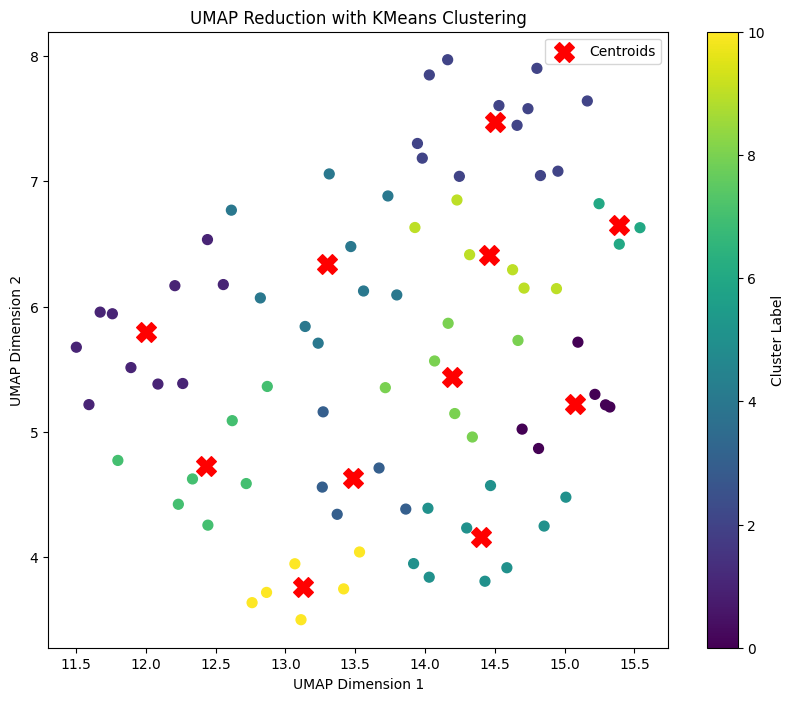

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.colorbar(scatter, label='Cluster Label')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Reduction with KMeans Clustering')
plt.legend()
plt.show()

In [19]:
# Create a subset of B using the mean loss sampled indices
subset_A = torch.utils.data.Subset(datasets["A"][0], closest_indices_per_cluster)
new_train = torch.utils.data.ConcatDataset([subset_A, datasets["B"][0]])

# Calculate new mean and std
pixel_mean_B,pixel_std_B=pixel_mean_std(new_train)
print("pixel mean of B",pixel_mean_B,"pixel std:",pixel_std_B)

datasets["B"] = (new_train, datasets["B"][1], datasets["B"][2])

m2f_preprocessor_B = Mask2FormerImageProcessor(
    reduce_labels=True,
    ignore_index=255,
    do_resize=False,
    do_rescale=True,
    do_normalize=True,
    image_std=pixel_std_B,
    image_mean=pixel_mean_B,
)

# Create Mask2Former Datasets
m2f_datasets = {
    "A": {
        "train": Mask2FormerDataset(datasets["A"][0], m2f_preprocessor_A),
        "val": Mask2FormerDataset(datasets["A"][1], m2f_preprocessor_A),
        "test": Mask2FormerDataset(datasets["A"][2], m2f_preprocessor_A),
    },
    "B": {
        "train": Mask2FormerDataset(datasets["B"][0], m2f_preprocessor_B),
        "val": Mask2FormerDataset(datasets["B"][1], m2f_preprocessor_B),
        "test": Mask2FormerDataset(datasets["B"][2], m2f_preprocessor_B),
    },
}

# DataLoader parameters
N_WORKERS = 4
BATCH_SIZE = 16
SHUFFLE = True
DROP_LAST = True

dataloader_params = {
    "batch_size": BATCH_SIZE,
    "shuffle": SHUFFLE,
    "num_workers": N_WORKERS,
    "drop_last": DROP_LAST,
    "pin_memory": True,
    "collate_fn": m2f_dataset_collate,
}

# Create DataLoaders
dataloaders = {
    key: create_dataloaders(m2f_datasets[key], **dataloader_params)
    for key in m2f_datasets
}

print(dataloaders)

pixel mean of B [0.32589011 0.29064861 0.21146446] pixel std: [0.30103154 0.25251702 0.21938567]
{'A': {'train': <torch.utils.data.dataloader.DataLoader object at 0x17fe56b70>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x17aff2030>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x17b0d9e80>}, 'B': {'train': <torch.utils.data.dataloader.DataLoader object at 0x17b0abad0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x319b83710>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x17b0dcf50>}}


# Now train on B and forget A

In [12]:
# Training
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
LR_MULTIPLIER = 0.1
BACKBONE_LR = LEARNING_RATE * LR_MULTIPLIER
WEIGHT_DECAY = 0.05
PATIENCE=15
encoder_params = [
    param
    for name, param in model.named_parameters()
    if name.startswith("model.pixel_level_module.encoder")
]
decoder_params = [
    param
    for name, param in model.named_parameters()
    if name.startswith("model.pixel_level_module.decoder")
]
transformer_params = [
    param
    for name, param in model.named_parameters()
    if name.startswith("model.transformer_module")
]
optimizer = optim.AdamW(
    [
        {"params": encoder_params, "lr": BACKBONE_LR},
        {"params": decoder_params},
        {"params": transformer_params},
    ],
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

scheduler = optim.lr_scheduler.PolynomialLR(
    optimizer, total_iters=NUM_EPOCHS, power=0.9
)

In [13]:
# WandB for team usage !!!!

wandb.login() # use this one if a different person is going to run the notebook
#wandb.login(relogin=False) # if the same person in the last run is going to run the notebook again


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ge85ket (continual-learning-tum). Use `wandb login --relogin` to force relogin


True

In [14]:
wandb.init(
    project="M2F_original",
    config={
        "learning_rate": LEARNING_RATE,
        "learning_rate_multiplier": LR_MULTIPLIER,
        "backbone_learning_rate": BACKBONE_LR,
        "learning_rate_scheduler": scheduler.__class__.__name__,
        "optimizer": optimizer.__class__.__name__,
        "backbone": SWIN_BACKBONE,
        "m2f_preprocessor": m2f_preprocessor_B.__dict__,
        "m2f_model_config": model.config
    },
    name="M2F-Swin-Tiny-RSS-32MBReplay",
    notes="M2F with tiny Swin backbone pretrained on ImageNet-1K. \
        Scenario: Pretrained on A, Train on B, Test 32MB RSS replay on A"
)

# Tensorboard logging
writer = SummaryWriter(log_dir=out_dir + "runs")

# Model checkpointing
model_name = "m2f_swin_backbone_replay_rss_32MBs"
model_dir = out_dir + "models/"
if not os.path.exists(model_dir):
    print("Store weights in: ", model_dir)
    os.makedirs(model_dir)

best_model_dir = model_dir + f"{model_name}/best_model/"
if not os.path.exists(best_model_dir):
    print("Store best model weights in: ", best_model_dir)
    os.makedirs(best_model_dir)
final_model_dir = model_dir + f"{model_name}/final_model/"
if not os.path.exists(final_model_dir):
    print("Store final model weights in: ", final_model_dir)
    os.makedirs(final_model_dir)

Store best model weights in:  outputs/models/m2f_swin_backbone_replay_random_32MBs/best_model/
Store final model weights in:  outputs/models/m2f_swin_backbone_replay_random_32MBs/final_model/


In [15]:
# Save the preprocessor
m2f_preprocessor_B.save_pretrained(model_dir + model_name)

['outputs/models/m2f_swin_backbone_replay_random_32MBs/preprocessor_config.json']

In [16]:
# To avoid making stupid errors
CURR_TASK = "B"

# For storing the model
best_val_metric = -np.inf

# Move model to device
model.to(device)
counter=0
for epoch in range(NUM_EPOCHS):
    model.train()
    train_running_loss = 0.0
    val_running_loss = 0.0

    # Set up tqdm for the training loop
    train_loader = tqdm(
        dataloaders[CURR_TASK]["train"], desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} Training"
    )

    for batch in train_loader:
        # Move everything to the device
        batch["pixel_values"] = batch["pixel_values"].to(device)
        batch["pixel_mask"] = batch["pixel_mask"].to(device)
        batch["mask_labels"] = [entry.to(device) for entry in batch["mask_labels"]]
        batch["class_labels"] = [entry.to(device) for entry in batch["class_labels"]]

        # Compute output and loss
        outputs = model(**batch)

        loss = outputs.loss

        # Compute gradient and perform step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record losses
        current_loss = loss.item() * batch["pixel_values"].size(0)
        train_running_loss += current_loss
        train_loader.set_postfix(loss=f"{current_loss:.4f}")

        # Extract and compute metrics
        pred_maps, masks = m2f_extract_pred_maps_and_masks(
            batch, outputs, m2f_preprocessor_B
        )
        metric.add_batch(references=masks, predictions=pred_maps)
        

    # After compute the batches that were added are deleted
    mean_train_iou = metric.compute(
        num_labels=NUM_CLASSES, ignore_index=BG_VALUE_255, reduce_labels=False
    )["mean_iou"]

    # Validation phase
    model.eval()
    val_loader = tqdm(
        dataloaders[CURR_TASK]["val"], desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} Validation"
    )
    with torch.no_grad():
        for batch in val_loader:
            # Move everything to the device
            batch["pixel_values"] = batch["pixel_values"].to(device)
            batch["pixel_mask"] = batch["pixel_mask"].to(device)
            batch["mask_labels"] = [entry.to(device) for entry in batch["mask_labels"]]
            batch["class_labels"] = [
                entry.to(device) for entry in batch["class_labels"]
            ]
            # Compute output and loss
            outputs = model(**batch)

            loss = outputs.loss
            # Record losses
            current_loss = loss.item() * batch["pixel_values"].size(0)
            val_running_loss += current_loss
            val_loader.set_postfix(loss=f"{current_loss:.4f}")

            # Extract and compute metrics
            pred_maps, masks = m2f_extract_pred_maps_and_masks(
                batch, outputs, m2f_preprocessor_B
            )
            metric.add_batch(references=masks, predictions=pred_maps)
            

    # After compute the batches that were added are deleted
    mean_val_iou = metric.compute(
        num_labels=NUM_CLASSES, ignore_index=BG_VALUE_255, reduce_labels=False
    )["mean_iou"]

    epoch_train_loss = train_running_loss / len(dataloaders[CURR_TASK]["train"].dataset)
    epoch_val_loss = val_running_loss / len(dataloaders[CURR_TASK]["val"].dataset)

    writer.add_scalar(f"Loss/train_{model_name}_{CURR_TASK}", epoch_train_loss, epoch + 1)
    writer.add_scalar(f"Loss/val_{model_name}_{CURR_TASK}", epoch_val_loss, epoch + 1)
    writer.add_scalar(f"mIoU/train_{model_name}_{CURR_TASK}", mean_train_iou, epoch + 1)
    writer.add_scalar(f"mIoU/val_{model_name}_{CURR_TASK}", mean_val_iou, epoch + 1)

    wandb.log({
        f"Loss/train_replay_A_{CURR_TASK}": epoch_train_loss,
        f"Loss/val_replay_A_{CURR_TASK}": epoch_val_loss,
        f"mIoU/train_replay_A_{CURR_TASK}": mean_train_iou,
        f"mIoU/val_replay_A_{CURR_TASK}": mean_val_iou
    })


    tqdm.write(
        f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Train mIoU: {mean_train_iou:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation mIoU: {mean_val_iou:.4f}"
    )
    
    if mean_val_iou > best_val_metric:
        best_val_metric = mean_val_iou
        model.save_pretrained(f"{best_model_dir}{CURR_TASK}/")
        counter=0
    else:
        counter+=1
        if counter == PATIENCE:
            print("Early stopping at epoch",epoch)
            break

Epoch 1/200 Validation: 100%|██████████| 14/14 [00:27<00:00,  1.98s/it, loss=257.0259]


Epoch 1/200, Train Loss: 21.7449, Train mIoU: 0.5215, Validation Loss: 16.0122, Validation mIoU: 0.5741


Epoch 2/200 Validation: 100%|██████████| 14/14 [00:28<00:00,  2.05s/it, loss=167.9487]


Epoch 2/200, Train Loss: 15.2879, Train mIoU: 0.6760, Validation Loss: 12.2397, Validation mIoU: 0.7253


Epoch 3/200 Validation: 100%|██████████| 14/14 [00:26<00:00,  1.88s/it, loss=130.3503]


Epoch 3/200, Train Loss: 11.7822, Train mIoU: 0.8015, Validation Loss: 10.8338, Validation mIoU: 0.8450


Epoch 4/200 Validation: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it, loss=151.8922]


Epoch 4/200, Train Loss: 10.5904, Train mIoU: 0.8275, Validation Loss: 10.0674, Validation mIoU: 0.7855


Epoch 5/200 Validation: 100%|██████████| 14/14 [00:25<00:00,  1.83s/it, loss=111.2459]


Epoch 5/200, Train Loss: 9.5099, Train mIoU: 0.8533, Validation Loss: 9.2441, Validation mIoU: 0.8357


Epoch 6/200 Validation: 100%|██████████| 14/14 [00:27<00:00,  1.96s/it, loss=113.4715]


Epoch 6/200, Train Loss: 8.7502, Train mIoU: 0.8747, Validation Loss: 8.8964, Validation mIoU: 0.8434


Epoch 7/200 Validation: 100%|██████████| 14/14 [00:25<00:00,  1.84s/it, loss=174.9991]


Epoch 7/200, Train Loss: 8.3743, Train mIoU: 0.8898, Validation Loss: 8.9075, Validation mIoU: 0.8386


Epoch 8/200 Validation: 100%|██████████| 14/14 [00:27<00:00,  1.94s/it, loss=162.7442]


Epoch 8/200, Train Loss: 8.1361, Train mIoU: 0.8704, Validation Loss: 8.5490, Validation mIoU: 0.8027


Epoch 9/200 Validation: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it, loss=183.9983]


Epoch 9/200, Train Loss: 7.5641, Train mIoU: 0.8998, Validation Loss: 8.6197, Validation mIoU: 0.9107


Epoch 10/200 Validation: 100%|██████████| 14/14 [00:26<00:00,  1.89s/it, loss=112.9628]


Epoch 10/200, Train Loss: 7.4078, Train mIoU: 0.9083, Validation Loss: 8.0314, Validation mIoU: 0.8028


Epoch 11/200 Validation: 100%|██████████| 14/14 [00:20<00:00,  1.43s/it, loss=116.9398]


Epoch 11/200, Train Loss: 7.1217, Train mIoU: 0.9205, Validation Loss: 8.6613, Validation mIoU: 0.8343


Epoch 12/200 Validation: 100%|██████████| 14/14 [00:28<00:00,  2.02s/it, loss=140.9732]


Epoch 12/200, Train Loss: 7.5331, Train mIoU: 0.9075, Validation Loss: 9.5564, Validation mIoU: 0.8651


Epoch 13/200 Validation: 100%|██████████| 14/14 [00:18<00:00,  1.35s/it, loss=187.3370]


Epoch 13/200, Train Loss: 8.0432, Train mIoU: 0.8823, Validation Loss: 9.0826, Validation mIoU: 0.7296


Epoch 14/200 Validation: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it, loss=112.5273]


Epoch 14/200, Train Loss: 7.0011, Train mIoU: 0.9080, Validation Loss: 8.2902, Validation mIoU: 0.8298


Epoch 15/200 Validation: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it, loss=141.4091]


Epoch 15/200, Train Loss: 6.5981, Train mIoU: 0.9150, Validation Loss: 8.3981, Validation mIoU: 0.8921


Epoch 16/200 Validation: 100%|██████████| 14/14 [00:19<00:00,  1.40s/it, loss=125.2526]


Epoch 16/200, Train Loss: 6.5371, Train mIoU: 0.9264, Validation Loss: 7.8387, Validation mIoU: 0.8245


Epoch 17/200 Validation: 100%|██████████| 14/14 [00:24<00:00,  1.73s/it, loss=171.4059]


Epoch 17/200, Train Loss: 6.1198, Train mIoU: 0.9510, Validation Loss: 9.1567, Validation mIoU: 0.8209


Epoch 18/200 Validation: 100%|██████████| 14/14 [00:23<00:00,  1.69s/it, loss=159.2204]


Epoch 18/200, Train Loss: 6.0228, Train mIoU: 0.9558, Validation Loss: 8.0672, Validation mIoU: 0.8175


Epoch 19/200 Validation: 100%|██████████| 14/14 [00:13<00:00,  1.07it/s, loss=125.7380]


Epoch 19/200, Train Loss: 5.8742, Train mIoU: 0.9459, Validation Loss: 7.7200, Validation mIoU: 0.7946


Epoch 20/200 Validation: 100%|██████████| 14/14 [00:13<00:00,  1.02it/s, loss=143.9437]


Epoch 20/200, Train Loss: 5.7186, Train mIoU: 0.9653, Validation Loss: 7.9545, Validation mIoU: 0.8387


Epoch 21/200 Validation: 100%|██████████| 14/14 [00:14<00:00,  1.01s/it, loss=131.6773]


Epoch 21/200, Train Loss: 5.7681, Train mIoU: 0.9508, Validation Loss: 7.7855, Validation mIoU: 0.7798


Epoch 22/200 Validation: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s, loss=106.4369]


Epoch 22/200, Train Loss: 5.5983, Train mIoU: 0.9547, Validation Loss: 7.6187, Validation mIoU: 0.8444


Epoch 23/200 Validation: 100%|██████████| 14/14 [00:12<00:00,  1.10it/s, loss=159.7783]


Epoch 23/200, Train Loss: 5.5626, Train mIoU: 0.9644, Validation Loss: 8.5713, Validation mIoU: 0.7716


Epoch 24/200 Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, loss=116.1913]


Epoch 24/200, Train Loss: 5.6227, Train mIoU: 0.9475, Validation Loss: 8.4482, Validation mIoU: 0.8347
Early stopping at epoch 23


## Test results on B first

In [17]:
# Load best model and evaluate on test
model = Mask2FormerForUniversalSegmentation.from_pretrained(f"{best_model_dir}{CURR_TASK}/").to(device)

In [18]:
model.eval()
test_running_loss = 0
test_loader = tqdm(dataloaders[CURR_TASK]["test"], desc="Test loop")
with torch.no_grad():
    for batch in test_loader:
        # Move everything to the device
        batch["pixel_values"] = batch["pixel_values"].to(device)
        batch["pixel_mask"] = batch["pixel_mask"].to(device)
        batch["mask_labels"] = [entry.to(device) for entry in batch["mask_labels"]]
        batch["class_labels"] = [entry.to(device) for entry in batch["class_labels"]]
        # Compute output and loss
        outputs = model(**batch)

        loss = outputs.loss
        # Record losses
        current_loss = loss.item() * batch["pixel_values"].size(0)
        test_running_loss += current_loss
        test_loader.set_postfix(loss=f"{current_loss:.4f}")

        # Extract and compute metrics
        pred_maps, masks = m2f_extract_pred_maps_and_masks(
            batch, outputs, m2f_preprocessor_B
        )
        metric.add_batch(references=masks, predictions=pred_maps)
        
    
# After compute the batches that were added are deleted
test_metrics_B = metric.compute(
    num_labels=NUM_CLASSES, ignore_index=BG_VALUE_255, reduce_labels=False
)
mean_test_iou = test_metrics_B["mean_iou"]
final_test_loss = test_running_loss / len(dataloaders[CURR_TASK]["test"].dataset)
wandb.log({
    f"Loss/test_{CURR_TASK}": final_test_loss,
    f"mIoU/test_{CURR_TASK}": mean_test_iou
})
print(f"Test Loss: {final_test_loss:.4f}, Test mIoU: {mean_test_iou:.4f}")

Test loop: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s, loss=219.2597]


Test Loss: 9.6078, Test mIoU: 0.8148


## Test results on A after training on B

In [19]:
# To avoid making stupid errors
CURR_TASK = "A"

model.eval()
test_running_loss = 0
test_loader = tqdm(dataloaders[CURR_TASK]["test"], desc="Test loop")
with torch.no_grad():
    for batch in test_loader:
        # Move everything to the device
        batch["pixel_values"] = batch["pixel_values"].to(device)
        batch["pixel_mask"] = batch["pixel_mask"].to(device)
        batch["mask_labels"] = [entry.to(device) for entry in batch["mask_labels"]]
        batch["class_labels"] = [entry.to(device) for entry in batch["class_labels"]]
        # Compute output and loss
        outputs = model(**batch)

        loss = outputs.loss
        # Record losses
        current_loss = loss.item() * batch["pixel_values"].size(0)
        test_running_loss += current_loss
        test_loader.set_postfix(loss=f"{current_loss:.4f}")

        # Extract and compute metrics
        pred_maps, masks = m2f_extract_pred_maps_and_masks(
            batch, outputs, m2f_preprocessor_A
        )
        metric.add_batch(references=masks, predictions=pred_maps)
        

# After compute the batches that were added are deleted
test_metrics_forgetting_A = metric.compute(
    num_labels=NUM_CLASSES, ignore_index=BG_VALUE_255, reduce_labels=False
)
mean_test_iou = test_metrics_forgetting_A["mean_iou"]

final_test_loss = test_running_loss / len(dataloaders[CURR_TASK]["test"].dataset)
wandb.log({
    f"Loss/test_random_replay_32mb_{CURR_TASK}": final_test_loss,
    f"mIoU/test_random_replay_32mb_{CURR_TASK}": mean_test_iou
})
print(f"Test Loss: {final_test_loss:.4f}, Test mIoU: {mean_test_iou:.4f}")


Test loop: 100%|██████████| 36/36 [00:31<00:00,  1.16it/s, loss=253.0399]


Test Loss: 18.0878, Test mIoU: 0.6331


In [20]:
# Collect overall mIoU
mIoU_A = test_metrics_A["mean_iou"]
mIoU_forgetting_A = test_metrics_forgetting_A["mean_iou"]
mIoU_B = test_metrics_B["mean_iou"]

# Collect per category mIoU
per_category_mIoU_A = np.array(test_metrics_A["per_category_iou"])
per_category_mIoU_forgetting_A = np.array(test_metrics_forgetting_A["per_category_iou"])
per_category_mIoU_B = np.array(test_metrics_B["per_category_iou"])

# Average learning accuracies (mIoUs)
avg_learning_acc = (mIoU_A + mIoU_B) / 2
per_category_avg_learning_acc = (per_category_mIoU_A + per_category_mIoU_B) / 2

# Forgetting
total_forgetting = mIoU_A - mIoU_forgetting_A
per_category_forgetting = (per_category_mIoU_A - per_category_mIoU_forgetting_A)

# Export evaluation metrics to WandB
wandb.log({
    "eval/avg_learning_acc": avg_learning_acc,
    "eval/per_category_avg_learning_acc": per_category_avg_learning_acc,
    "eval/total_forgetting": total_forgetting,
    "eval/per_category_forgetting": per_category_forgetting
})
print("**** Overall mIoU ****")
print(f"mIoU on task A: {mIoU_A}")
print(f"mIoU on task B: {mIoU_B}")
print(f"mIoU on task A after training on B: {mIoU_forgetting_A}")

print("\n**** Per category mIoU ****")
print(f"Per category mIoU on task A: {per_category_mIoU_A}")
print(f"Per category mIoU on task B: {per_category_mIoU_B}")
print(f"Per category mIoU on task A after training on B: {per_category_mIoU_forgetting_A}")

print("\n**** Average learning accuracies ****")
print(f"Average learning acc.: {avg_learning_acc}")
print(f"Per category Average learning acc.: {per_category_avg_learning_acc}")

print("\n**** Forgetting ****")
print(f"Total forgetting: {total_forgetting}")
print(f"Per category forgetting: {per_category_forgetting}")
wandb.finish()

**** Overall mIoU ****
mIoU on task A: 0.7877320741744921
mIoU on task B: 0.8147568601689673
mIoU on task A after training on B: 0.6331341976113071

**** Per category mIoU ****
Per category mIoU on task A: [0.95360882 0.91871854 0.687211   0.63869946 0.28185184 0.81372453
 0.79456505 0.78816018 0.91600346 0.94137199 0.93113795]
Per category mIoU on task B: [0.64883466 0.92158785 0.66189335 0.42188805 0.91321486 0.92138359
 0.87228751 0.9090481  0.83385892 0.90736424 0.95096433]
Per category mIoU on task A after training on B: [0.94367449 0.89510091 0.38542904 0.0054243  0.08066265 0.70086898
 0.51268752 0.69792442 0.87838144 0.93594176 0.92838067]

**** Average learning accuracies ****
Average learning acc.: 0.8012444671717297
Per category Average learning acc.: [0.80122174 0.92015319 0.67455217 0.53029376 0.59753335 0.86755406
 0.83342628 0.84860414 0.87493119 0.92436812 0.94105114]

**** Forgetting ****
Total forgetting: 0.15459787656318502
Per category forgetting: [0.00993433 0.0236

Loss/test_B,▁
Loss/test_random_replay_32mb_A,▁
Loss/train_replay_A_B,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Loss/val_replay_A_B,█▅▄▃▂▂▂▂▂▁▂▃▂▂▂▁▂▁▁▁▁▁▂▂
eval/avg_learning_acc,▁
eval/total_forgetting,▁
mIoU/test_B,▁
mIoU/test_random_replay_32mb_A,▁
mIoU/train_replay_A_B,▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇▇████████
mIoU/val_replay_A_B,▁▄▇▅▆▇▆▆█▆▆▇▄▆█▆▆▆▆▇▅▇▅▆
Loss/test_B,9.6078


In [21]:
per_category_mIoU_A,per_category_mIoU_B, per_category_mIoU_forgetting_A,per_category_avg_learning_acc,per_category_forgetting,

(array([0.95360882, 0.91871854, 0.687211  , 0.63869946, 0.28185184,
        0.81372453, 0.79456505, 0.78816018, 0.91600346, 0.94137199,
        0.93113795]),
 array([0.64883466, 0.92158785, 0.66189335, 0.42188805, 0.91321486,
        0.92138359, 0.87228751, 0.9090481 , 0.83385892, 0.90736424,
        0.95096433]),
 array([0.94367449, 0.89510091, 0.38542904, 0.0054243 , 0.08066265,
        0.70086898, 0.51268752, 0.69792442, 0.87838144, 0.93594176,
        0.92838067]),
 array([0.80122174, 0.92015319, 0.67455217, 0.53029376, 0.59753335,
        0.86755406, 0.83342628, 0.84860414, 0.87493119, 0.92436812,
        0.94105114]),
 array([0.00993433, 0.02361763, 0.30178196, 0.63327516, 0.20118919,
        0.11285555, 0.28187753, 0.09023576, 0.03762203, 0.00543023,
        0.00275727]))